In [37]:
import meva
from meva.lib.spin import get_pretrained_hmr
import mmcv 
import torch
from meva.utils import image_utils
import utils
from utils import imshownp
from skimage.transform import resize
import numpy as np
import data
from utils import makedirs_ifno
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from meva.utils import kp_utils
from matplotlib.pyplot import cm
import scipy
from smplx.lbs import vertices2joints

# Run SPIN

In [68]:
from importlib import reload
reload(data)

<module 'data' from '/home/tormod/Documents/APEC/data.py'>

In [3]:
out_folder = '/home/tormod/ucph-erda-home/hmr_results'
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
c = data.ClimbingDataset('all', 
                         feat_folder=None,
                         video_folder = vid_folder,
                         seq_len=1)

In [27]:
d = c.get(0)

In [30]:
hmr = get_pretrained_hmr()

====> Loading pre trained: data/meva_data/spin_model_checkpoint.pth.tar


In [29]:
hmr.eval()
imgs = d['norm_imgs']
imgs = imgs[:1]
imgs = imgs.float().to('cuda')
feat, out = hmr(imgs, return_features=True)

In [25]:
for i in trange(len(c)):
    d = c.get(i)
    img = d['norm_imgs']
    img = imgs.float().to('cuda')
    feat, out = hmr(img, return_features=True)

/home/tormod/Documents/APEC/meva/utils/image_utils.py:384: RuntimeWarning: invalid value encountered in double_scalars
  w = h = np.where(w / h > 1, w, h)


KeyboardInterrupt: 

In [4]:
res = np.load(f'{out_folder}/{data.stripped_names[0]}.npy', allow_pickle=True)
out = res

In [5]:
out[0].keys()

dict_keys(['theta', 'verts', 'kp_2d', 'kp_3d', 'features'])

In [6]:
frameid = 2*90+50
d = c.get(frameid)

In [7]:
d.keys()

dict_keys(['raw_imgs', 'norm_imgs', 'features', 'raw_kp_2d', 'kp_2d', 'vid_idx', 'frames', 'bboxes', 'trans', 'inv_trans'])

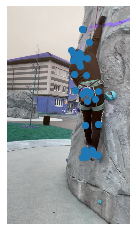

In [8]:
img = d['raw_imgs'][0]
norm_img = d['norm_imgs'][0]
imshownp(img)
kp_2d = out[frameid]['kp_2d'][0]
kp_2d = image_utils.normalize_2d_kp(kp_2d, inv=True)
#kp_3d = out[0]['kp_3d'].cpu().detach().numpy()[0]
kp_2d = image_utils.trans_points2d(kp_2d, d['inv_trans'])
plt.scatter(kp_2d[:,0], kp_2d[:,1])

[0.7955612  0.06449877 0.3105799 ]


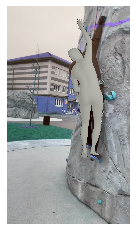

In [12]:
import mesh
reload(mesh)
verts = out[frameid]['verts'][0].copy()
theta = out[frameid]['theta'][0].copy()
bboxes = d['bboxes']
pred_cam = theta[:3]
print(pred_cam)
pred_cam[0] *= 1.2
imshownp(mesh.render_pred_mesh(img, bboxes, verts, pred_cam))

# Render results

In [70]:
from meva.utils.renderer import Renderer
from meva.utils.demo_utils import convert_crop_cam_to_orig_img
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
def render_vids(cd, res, out_folder, vid_idx):
    vid = cd.vids[vid_idx]
    vid_name = data.stripped_names[vid_idx]
    cd.load_labels(vid_name)
    bboxes = cd.bboxes[vid_name]
    orig_width, orig_height = vid.resolution
    renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)
    for frame, r in tqdm(enumerate(res), total=(len(res))):
        img = vid[frame]
        verts = r['verts'][0]
        pred_cam = r['theta'][:, :3].copy()
        pred_cam[:, 0] *= 1.2
        bbox = bboxes[np.newaxis,frame]
        orig_cam = convert_crop_cam_to_orig_img(
            pred_cam, bbox, orig_width, orig_height)[0]
        mesh_img = renderer.render(img, verts, orig_cam)
        
        black_img = renderer.render(np.zeros_like(img), verts, orig_cam)  
        
        out_img = np.concatenate([black_img, mesh_img], axis=1)
        mmcv.imwrite(out_img, f'{out_folder}/{vid_name}/{frame:06d}.png')

    mmcv.frames2video(f'{out_folder}/{vid_name}', f'{out_folder}/{vid_name}.mp4',
                      filename_tmpl='{:06d}.png')

In [83]:
in_folder = '/home/tormod/ucph-erda-home/hmr_results'
out_folder = '/media/tormod/Den Lille/Thesis/hmr_results'
vid_idx = 0
vid_name = data.stripped_names[vid_idx]
res = np.load(f'{in_folder}/{vid_name}.npy', allow_pickle=True)

In [85]:
vid_folder = '/media/tormod/Den Lille/Thesis/videos'
cd = data.ClimbingDataset('all', video_folder=vid_folder)

In [86]:
render_vids(cd, res, out_folder, vid_idx)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6829/6829, 27.7 task/s, elapsed: 247s, ETA:     0s


# Eval Results

In [81]:
from meva.lib.smpl import SMPL, SMPL_MODEL_DIR
from meva.lib import meva_model
smpl = SMPL(SMPL_MODEL_DIR,
            batch_size=64,
            create_transl=False)
smpl_feet_and_hands = [11,10,23,22]
climb_feet_and_hands = [12,16,4,8]
def get_smpl_joints(verts, pred_cam):
    smpl_joints = vertices2joints(smpl.J_regressor, torch.Tensor(verts))
    joints2d = meva_model.projection(smpl_joints, torch.Tensor(pred_cam))
    return joints2d.numpy()
    
def get_extra_joints(r):
    v = r['verts'].copy()
    theta = r['theta'].copy()
    pc = theta[:, :3]
    smpl_joints2d = get_smpl_joints(v, pc)
    return smpl_joints2d[:, smpl_feet_and_hands, :]

In [111]:
in_folder = '/home/tormod/ucph-erda-home/hmr_results'
def eval_res(split):
    cd = data.ClimbingDataset(split, preload_all=True)
    current_vid_name = ''
    res = []
    scores, acc_errs = [], []
    for seq_info in tqdm(cd):
        inv_trans = seq_info['inv_trans']
        vid_idx = seq_info['vid_idx']
        vid_name = data.stripped_names[vid_idx]
        if vid_name != current_vid_name:
            res = np.load(f'{in_folder}/{vid_name}.npy', allow_pickle=True)
            current_vid_name = vid_name
        scales = seq_info['bboxes'][:,-1]
        frames = seq_info['frames']
        pred_seq = np.concatenate([r['kp_2d'].copy() for r in res[frames[0]:frames[-1]+1]])
        gt_seq = seq_info['kp_2d'].numpy()
        oks_score = utils.oks(pred_seq, gt_seq, scales, inv_trans)
        acc_err = acceleration(pred_seq) - acceleration(gt_seq)
        if split in ['test', 'val', 'testval']:
            pred_extra_seq = np.concatenate([get_extra_joints(r) for r in res[frames[0]:frames[-1]+1]])

            gt_extra_seq = seq_info['kp_2d_extra'][:,climb_feet_and_hands,:]
            oks_extra = utils.oks_extra(pred_extra_seq, gt_extra_seq, scales, inv_trans)
            oks_score = np.concatenate((oks_score, oks_extra), axis=1)
            
            acc_extra = acceleration(pred_extra_seq) - acceleration(gt_extra_seq)
            acc_errs = np.concatenate((acc_errs, acc_extra), axis=1)
        scores.append(oks_score)
        acc_errs.append(acc_err)
    scores = np.stack(scores)
    scores = scores.reshape(-1, scores.shape[-1])
    # delete values for eye joints
    scores = np.delete(scores, 1, 1)
    scores = np.delete(scores, 1, 1)
    
    acc_errs = np.stack(acc_errs)
    acc_errs = acc_errs.reshape(-1, acc_errs.shape[-1])
    return scores, acc_errs

def score_per_frame(oks_score):
    conv_N = 3*90
    smooth_oks_score = scipy.ndimage.convolve(oks_score, np.ones((conv_N, 1))/conv_N, mode='mirror')
    plt.plot(smooth_oks_score.mean(axis=1))
    plt.ylim((0,1))
    
def score_per_joint_per_frame(oks_score):
    colors = cm.tab20(np.linspace(0,1,19))
    coco_joint_names = kp_utils.get_coco_joint_names()
    coco_joint_names = coco_joint_names[:1] + coco_joint_names[3:]
    climb_names = np.array(data.get_climb_joint_names())[climb_feet_and_hands]
    coco_joint_names = coco_joint_names + list(climb_names)
    conv_N = 3*90
    for j in range(oks_score.shape[1]):
        j_oks = oks_score[:,j].copy()
        j_oks = scipy.ndimage.convolve(j_oks, np.ones(conv_N)/conv_N, mode='mirror')
        plt.plot(j_oks, label=coco_joint_names[j], color=colors[j])
    plt.legend(loc='lower left', ncol=2)
    plt.ylim((0,1))
    
    
def speed(joints):
    return np.gradient(joints, axis=0)
    
def acceleration(joints):
    return np.gradient(speed(joints), axis=0)
    

In [112]:
reload(utils)
oks_testval, acc_err_testval = eval_res('testval')

ValueError: operands could not be broadcast together with shapes (90,49,2) (90,49,3) 

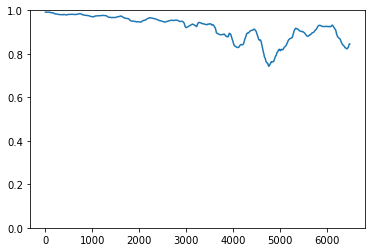

In [83]:
score_per_frame(oks_testval)

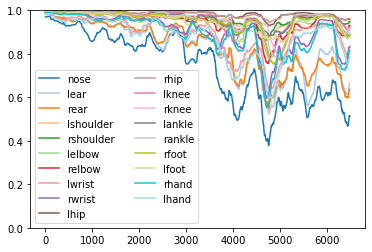

In [92]:
score_per_joint_per_frame(oks_testval)

In [7]:
oks_testval.mean(axis=0)

array([0.74359275, 0.82626425, 0.83008756, 0.96828544, 0.96864277,
       0.94328309, 0.94831708, 0.89308504, 0.90387804, 0.98434772,
       0.98414562, 0.95992033, 0.96128032, 0.96130897, 0.95602899])